<div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#2E4057;overflow:hidden"><b>Drone vs Non-Drone Classification using Deep Learning</b></div>

<div style="background-color:#F0F8FF; padding:25px; font-size:16px;color:#2E4057; border-radius:10px">

# Project Overview

This project implements a binary image classification system to distinguish between drones and non-drones using deep learning techniques. The model leverages transfer learning with EfficientNet50 architecture and provides comprehensive performance analysis including uncertainty estimation.

**Key Features:**
- Transfer learning with pre-trained EfficientNet50
- Data augmentation for improved generalization
- Using Dropout and Batch Normalization for better results 
- Statistical analysis
- Comprehensive visualization and evaluation metrics

**Dataset:** Drone vs Non-Drone image dataset with balanced binary classification

**Objective:** Build a robust classifier that can accurately distinguish between birds and drones while providing confidence estimates for predictions.

</div>

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">
    
<h2 id="setup">Setup and Library Imports</h2>

Setting up the environment with all necessary libraries for deep learning, data manipulation, and visualization. Random seeds are configured for reproducible results across different runs.

</div>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2025-12-08 13:24:55.497946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765200295.701240      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765200295.766509      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.8.0


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="data">Data Loading and Preprocessing</h2>

Loading the Birds vs Drones dataset and creating train/validation/test splits. The dataset is automatically explored to understand its structure and ensure proper loading for binary classification.

</div>

In [2]:
# data_dir = './data'
data_dir = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone'
birds_path = os.path.join(data_dir, 'Birds')
drones_path = os.path.join(data_dir, 'Drones')

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="augment">Data Augmentation Configuration</h2>

Implementing data augmentation techniques to improve model generalization. Random transformations include horizontal/vertical flips, rotation, and zoom operations to create diverse training samples.

</div>

In [3]:
print(len(os.listdir(birds_path)))
print(len(os.listdir(drones_path)))

400
428


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [5]:
new_directory_name = "dataset"
os.makedirs(os.path.join("/kaggle/working/", (new_directory_name + "/drone")), exist_ok=True)
os.makedirs(os.path.join("/kaggle/working/", (new_directory_name + "/non-drone")), exist_ok=True)

In [6]:
for file in os.listdir(drones_path):
    img_path = os.path.join(drones_path  , file)
    img = img_to_array(load_img(img_path  , target_size = (256 , 256)))
    input_batch = img.reshape(1 , 256 , 256 , 3)
    i = 0
    for output in datagen.flow(input_batch , batch_size = 1 , save_to_dir = '/kaggle/working/dataset/drone'):
        i = i+1 
        if i == 5 :
            break 

In [7]:
for file in os.listdir(birds_path):
    img_path = os.path.join(birds_path  , file)
    img = img_to_array(load_img(img_path  , target_size = (256 , 256)))
    input_batch = img.reshape(1 , 256 , 256 , 3)
    i = 0
    for output in datagen.flow(input_batch , batch_size = 1 , save_to_dir = '/kaggle/working/dataset/non-drone'):
        i = i+1 
        if i == 5 :
            break 

In [8]:
actual_data_dir = "/kaggle/working/dataset"

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    actual_data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    actual_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)
val_dataset = val_dataset.skip(val_batches // 2)

class_names = train_dataset.class_names
print("Class names:", class_names)

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset)}")

Found 3721 files belonging to 2 classes.
Using 2977 files for training.


I0000 00:00:1765200445.878843      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3721 files belonging to 2 classes.
Using 744 files for validation.
Class names: ['drone', 'non-drone']
Training batches: 94
Validation batches: 12
Test batches: 12


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="model">Model Architecture</h2>

Building a transfer learning model using EfficientNetB0 as the backbone. The architecture includes data augmentation, global average pooling, dropout for regularization, and a final dense layer for binary classification.

</div>

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , BatchNormalization , Dropout 
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256 , 256,3)),
    BatchNormalization() , 
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization() ,
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization() ,
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="compile">Model Compilation</h2>

Configuring the model for training with Adam optimizer, binary crossentropy loss, and accuracy metric. The learning rate is set to 1e-4 for stable convergence.

</div>

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,856,513 (56.67 MB)

 Trainable params: 14,856,065 (56.67 MB)

 Non-trainable params: 448 (1.75 KB)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="train">Model Training</h2>

Training the model for 15 epochs with both training and validation datasets. The training history is stored for later analysis and visualization.

</div>

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1
)

Epoch 1/30


I0000 00:00:1765200452.301354     118 service.cc:148] XLA service 0x7c22a8015120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765200452.302062     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765200452.933181     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5913 - loss: 1.3443

I0000 00:00:1765200458.542818     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.7290 - loss: 0.9129 - val_accuracy: 0.6361 - val_loss: 1.0910
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8176 - loss: 0.5059 - val_accuracy: 0.8028 - val_loss: 0.4710
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8944 - loss: 0.2915 - val_accuracy: 0.8528 - val_loss: 0.4152
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9257 - loss: 0.2068 - val_accuracy: 0.8639 - val_loss: 0.4846
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9324 - loss: 0.1927 - val_accuracy: 0.8333 - val_loss: 0.4801
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9507 - loss: 0.1265 - val_accuracy: 0.8278 - val_loss: 0.5398
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9501 - loss: 0.1306 - val_accuracy: 0.8278 - val_loss: 0.7659
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9608 - loss: 0.1195 - val_accuracy: 0.8417 - val_loss: 0

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="result">Training Results Visualizatio </h2>

Visualizing training progress through accuracy and loss curves. These plots help identify overfitting, underfitting, and overall model convergence patterns.

</div>

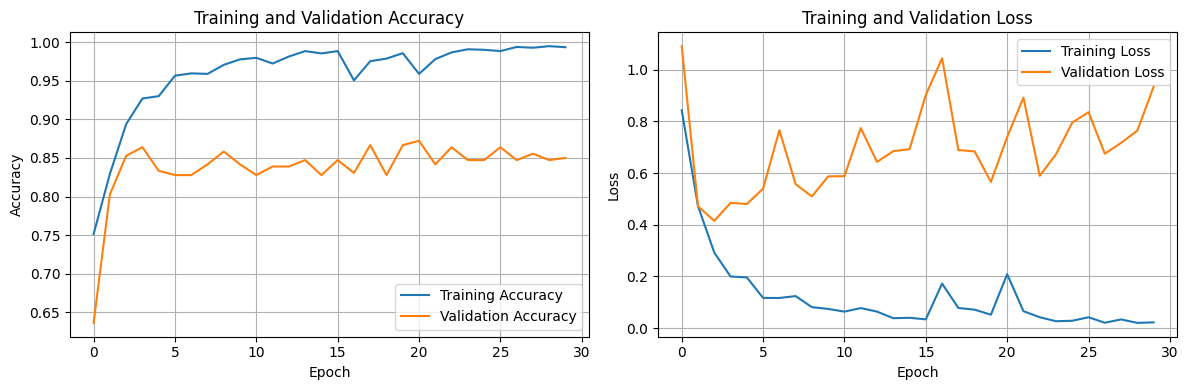

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="eval">Model Evaluation</h2>

Comprehensive evaluation of model performance on test data including accuracy metrics, confusion matrix visualization, and detailed classification report.

</div>

Test accuracy: 0.8698
Test loss: 0.6597


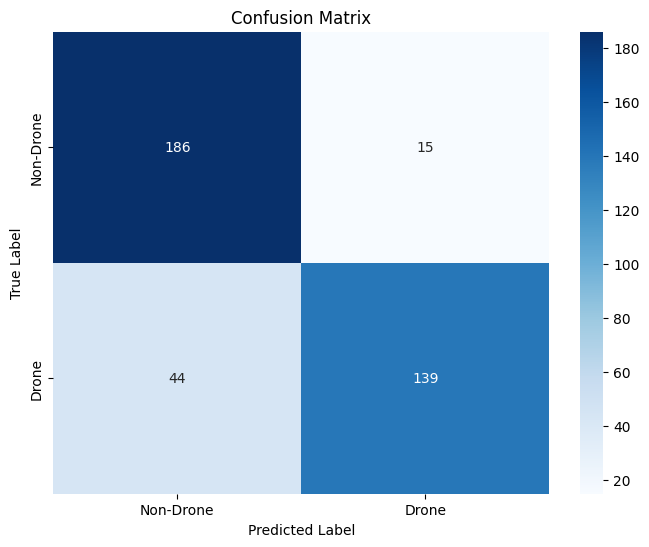


Classification Report:
              precision    recall  f1-score   support

        Bird       0.81      0.93      0.86       201
       Drone       0.90      0.76      0.82       183

    accuracy                           0.85       384
   macro avg       0.86      0.84      0.84       384
weighted avg       0.85      0.85      0.84       384



In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Drone', 'Drone'], 
            yticklabels=['Non-Drone', 'Drone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird', 'Drone']))

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="uncertainty">Uncertainty Visualization</h2>

Visual analysis of prediction confidence and uncertainty for individual test samples. Green titles indicate correct predictions while red indicates incorrect ones.

</div>

In [20]:
def mc_predict(model, images, T=20):
    predictions = []
    for _ in range(T):
        pred = model(images, training=True)
        predictions.append(pred)
    
    return tf.stack(predictions)

test_images, test_labels = next(iter(test_dataset))

mc_predictions = mc_predict(model, test_images, T=20)

mean_predictions = tf.reduce_mean(mc_predictions, axis=0)
uncertainty = tf.math.reduce_variance(mc_predictions, axis=0)

mean_predictions = mean_predictions.numpy()
uncertainty = uncertainty.numpy()
test_labels = test_labels.numpy()

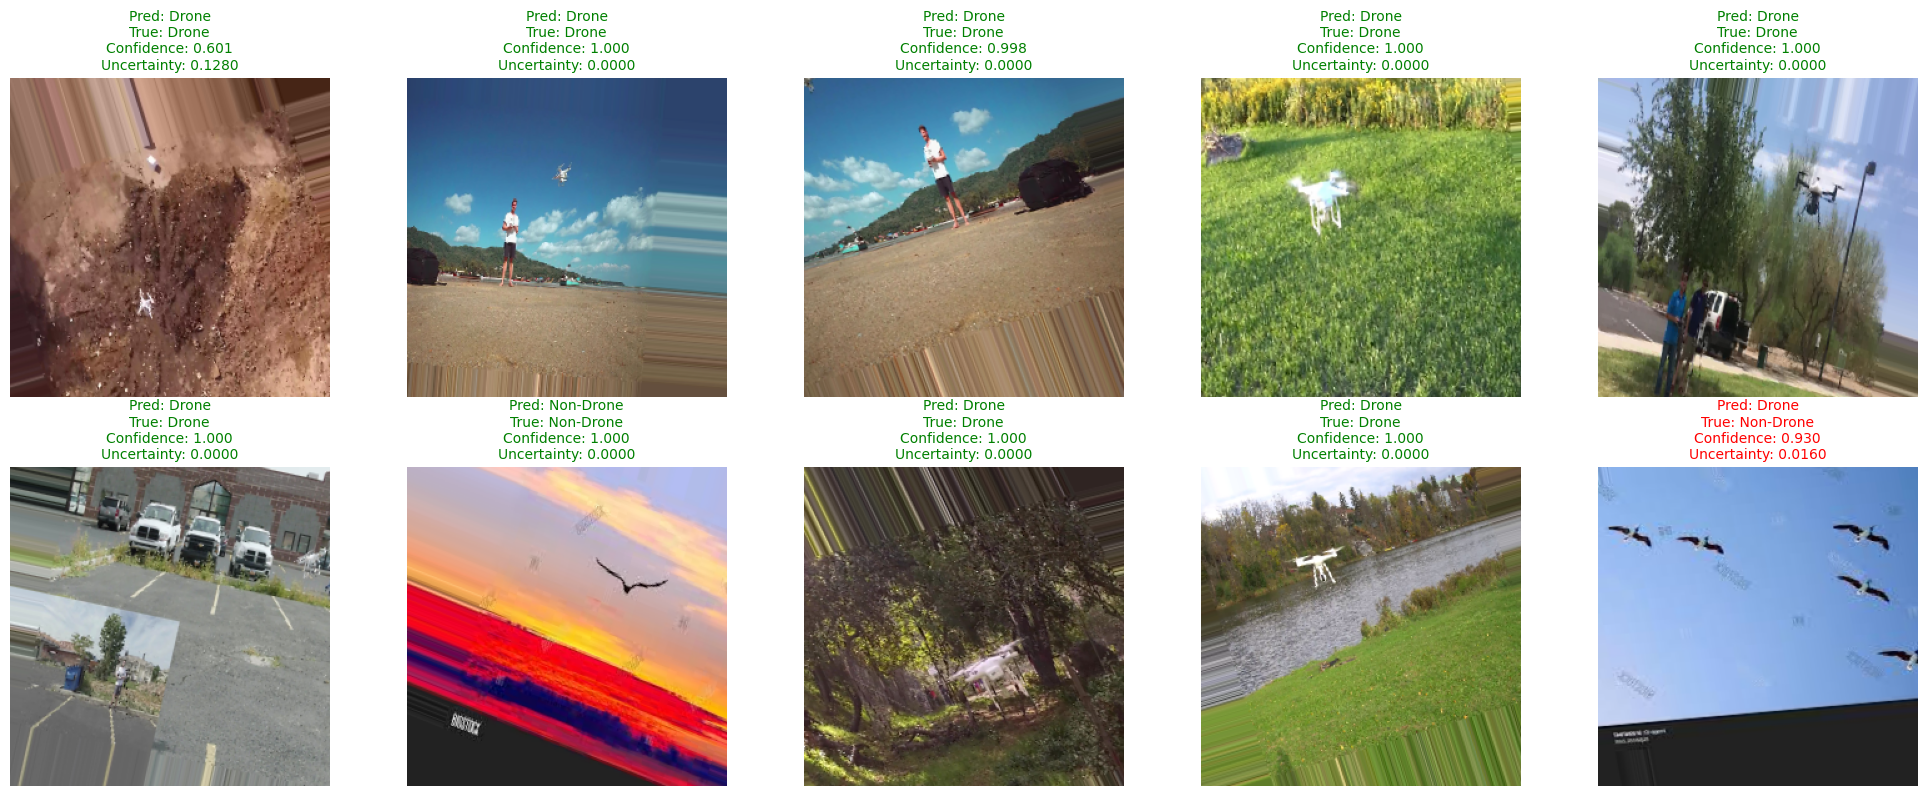

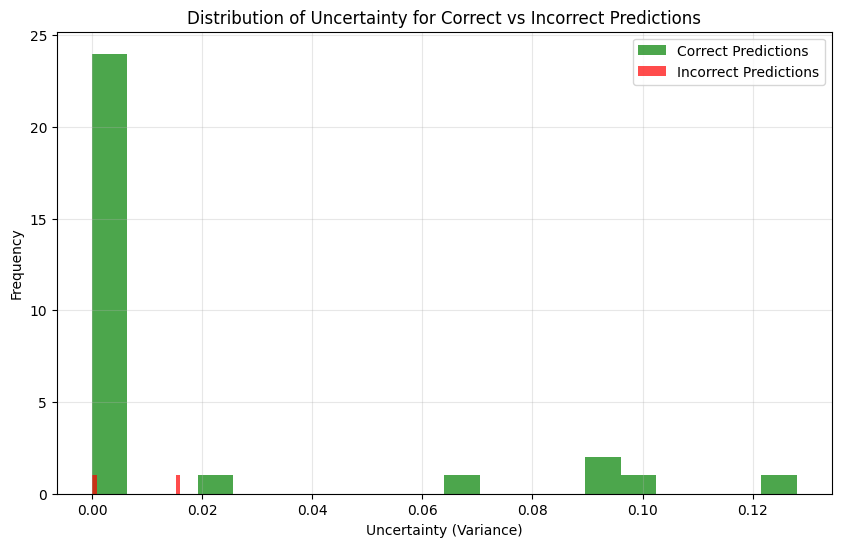

Average uncertainty for correct predictions: 0.0171
Average uncertainty for incorrect predictions: 0.0080
Total test samples: 32
Correct predictions: 30
Incorrect predictions: 2


In [21]:
plt.figure(figsize=(20, 8))

for i in range(min(10, len(test_images))):
    plt.subplot(2, 5, i + 1)
    
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.axis('off')
    
    pred_prob = mean_predictions[i][0]
    pred_class = 'Non-Drone' if pred_prob > 0.5 else 'Drone'
    true_class = 'Non-Drone' if test_labels[i] == 1 else 'Drone'
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    uncertainty_score = uncertainty[i][0]
    
    is_correct = (pred_prob > 0.5) == (test_labels[i] == 1)
    title_color = 'green' if is_correct else 'red'
    
    title = f"Pred: {pred_class}\nTrue: {true_class}\nConfidence: {confidence:.3f}\nUncertainty: {uncertainty_score:.4f}"
    
    plt.title(title, color=title_color, fontsize=10)

plt.tight_layout()
plt.show()

correct_predictions = (mean_predictions.flatten() > 0.5) == (test_labels.flatten() == 1)
uncertainty_flat = uncertainty.flatten()

uncertainty_correct = uncertainty_flat[correct_predictions]
uncertainty_incorrect = uncertainty_flat[~correct_predictions]

plt.figure(figsize=(10, 6))
plt.hist(uncertainty_correct, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(uncertainty_incorrect, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.xlabel('Uncertainty (Variance)')
plt.ylabel('Frequency')
plt.title('Distribution of Uncertainty for Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average uncertainty for correct predictions: {np.mean(uncertainty_correct):.4f}")
print(f"Average uncertainty for incorrect predictions: {np.mean(uncertainty_incorrect):.4f}")
print(f"Total test samples: {len(test_labels)}")
print(f"Correct predictions: {np.sum(correct_predictions)}")
print(f"Incorrect predictions: {np.sum(~correct_predictions)}")

In [31]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

e_model = tf.keras.Model(inputs, outputs)
e_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [32]:
e_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

history = e_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1
)

Epoch 1/30


E0000 00:00:1765201516.204305      38 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.7254 - loss: 0.5811 - val_accuracy: 0.8361 - val_loss: 0.4830
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8434 - loss: 0.4691 - val_accuracy: 0.8611 - val_loss: 0.4177
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8661 - loss: 0.4158 - val_accuracy: 0.9028 - val_loss: 0.3656
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8872 - loss: 0.3745 - val_accuracy: 0.9167 - val_loss: 0.3416
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8936 - loss: 0.3428 - val_accuracy: 0.9111 - val_loss: 0.3285
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9013 - loss: 0.3222 - val_accuracy: 0.9333 - val_loss: 0.2966
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9045 - loss: 0.3044 - val_accuracy: 0.9361 - val_loss: 0.2767
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9168 - loss: 0.2782 - val_accuracy: 0.9639 - val_loss: 

In [33]:
e_model.save('/kaggle/working/e_model_new.h5')

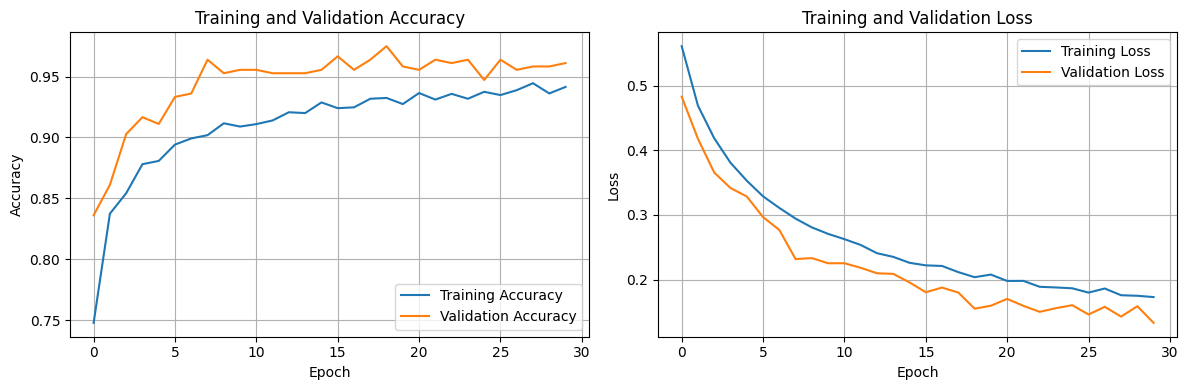

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test accuracy: 0.9635
Test loss: 0.1430


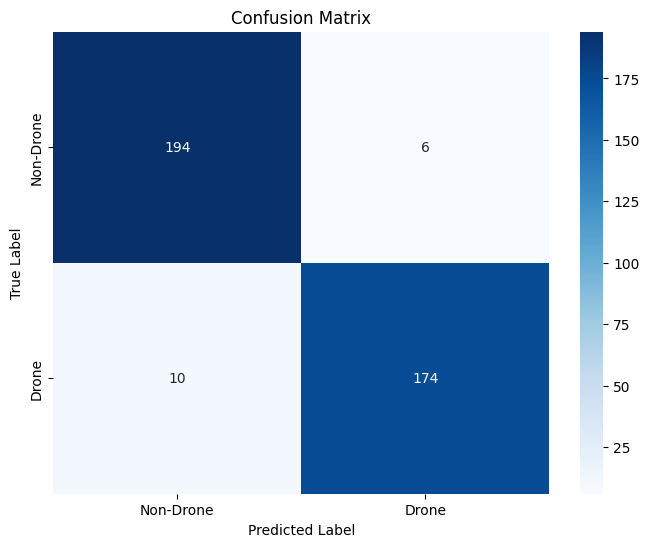


Classification Report:
              precision    recall  f1-score   support

        Bird       0.95      0.97      0.96       200
       Drone       0.97      0.95      0.96       184

    accuracy                           0.96       384
   macro avg       0.96      0.96      0.96       384
weighted avg       0.96      0.96      0.96       384



In [36]:
test_loss, test_accuracy = e_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = e_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Drone', 'Drone'], 
            yticklabels=['Non-Drone', 'Drone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird', 'Drone']))